In [1]:
import uproot
import awkward as ak #The events object is an awkward array
## Plotting.
import matplotlib.pyplot as plt

# Hists
import hist
from hist import Hist
import pickle #to save histograms

# NanoEvents
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# Processors (for parallelization)
#import coffea.processor as processor
from coffea import processor

#Math
import math

#Numpy
import numpy as np

#PackedSelection (to mask events)
from coffea.analysis_tools import PackedSelection

#Clock to count time
import time

In [2]:
#Function returning masks to select events of interest, used later in MyProcessor class
def ev_mask(old_events):
    #Implement the selections to veto events
    selection = PackedSelection()
        
    #Inclusive region for the HT, one charged lepton with pT > 15 GeV
    selection.add("inclusive_lepton_pT", ak.any(old_events.Electron.pt > 15.0, axis=1) | ak.any(old_events.Muon.pt > 15.0, axis=1))
        
    #At least one lepton 
    selection.add("one_l", (ak.num(old_events.Electron)+ak.num(old_events.Muon))>=1)
        
    #Electron signal region
    #The electron with higher pT (position 0) is tightly identified (Working Point 90) and isolated
    selection.add("fst_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].mvaFall17V2Iso_WP90 == True)
    selection.add(
        "electron_pT",
        ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].pt > 35.0
        #ak.any(old_events.Electron.pt > 35.0, axis=1)  
    )
    selection.add(
        "e_range_eta",
        ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].eta < 2.5
        #ak.any(abs (old_events.Electron.eta) < 2.5, axis=1)
    )
    #The following cuts work in inverse logic, when you require the selection later you must take false
    #Veto events if there is a second tight electron
    selection.add("snd_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WP90 == True)
    #Events containing a second loosely identified electron with pT > 10 GeV are vetoed.
    selection.add("loose_e", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
    #Veto events if there is any tight muon
    selection.add("any_tight_mu", ak.any(old_events.Muon.tightId == True, axis=1))
    #Events containing a second loosely identified muon with pT > 10 GeV are vetoed
    selection.add("loose_mu1", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 0].looseId == True) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 0].pt >10))
    selection.add("loose_mu2", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].looseId == True) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].pt >10))
        
    #Muon signal region
    #The muon with higher pT (position 0) is tightly identified and isolated
    selection.add("fst_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].tightId == True)
    selection.add(
        "muon_pT",
        ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].pt > 30.0
        #ak.any(old_events.Muon.pt >= 30.0, axis=1)
    )
    selection.add(
        "mu_range_eta",
        ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].eta < 2.4
        #ak.any(abs (old_events.Muon.eta) < 2.4, axis=1)
    )
    #The following cuts work in inverse logic, when you require the selection later you must take false
    #Veto events if there is a second tight muon
    selection.add("snd_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].tightId == True)
    #Events containing a second loosely identified muon with pT > 10 GeV are vetoed.
    selection.add("loose_mu", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].looseId == True) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].pt >10))
    #Veto events if there is any tight electron
    selection.add("any_tight_e", ak.any(old_events.Electron.mvaFall17V2Iso_WP90 == True, axis=1))
    #Events containing a second loosely identified electron with pT > 10 GeV are vetoed.
    selection.add("loose_e1", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].pt >10))
    selection.add("loose_e2", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
    
    #Puppy (pileup-per-particle identification algorithm) met cut (requiring moderate amount of missing transverse momentum)
    selection.add("lead_pMET", old_events.PuppiMET.pt>30)
    #b Veto (no bjet candidates are found according to the loose working point of the DeepCSV tagger)
    selection.add("b_veto", ak.all(old_events.Jet.btagDeepB<=0.84, axis=1))
    #VBS jets (looking for the max invariant mass pair)
    # Get all combinations of jet pairs in every event
    dijets_o = ak.combinations(old_events.Jet, 2, fields=['i0', 'i1'])
    # Check that jet pairs have the greatest mass
    ismax_o=(dijets_o['i0']+dijets_o['i1']).mass==ak.max((dijets_o['i0']+dijets_o['i1']).mass, axis=1)
    #previous line: returns a Boolean array with True where the condition is met, and false otherwise
    # Mask the dijets with the ismax to get dijets with the gratest mass
    VBS_jets_o = dijets_o[ismax_o]
    # Separate pairs into arrays of the leading and the trailing VBS jets in each pair
    VBS_ljet_o, VBS_tjet_o = ak.unzip(VBS_jets_o)
    #VBS selection
    selection.add(
        "lead_VBS_ljet",   
        ak.all(VBS_ljet_o.pt>50, axis=1)
    )
    selection.add(
        "lead_VBS_tjet", 
        ak.all(VBS_tjet_o.pt>30, axis=1)
    )
    selection.add(
        "lead_VBS_mass",
        ak.all((VBS_ljet_o+VBS_tjet_o).mass>500, axis=1)
    )
    selection.add(
        "lead_VBS_eta",
        ak.all(abs(VBS_ljet_o.eta-VBS_tjet_o.eta)>2.5, axis=1)
    )
                      
    #An event is assigned to a boosted category if it contains only one AK8 jet (fatjet) as hadronically decaying vector boson V_had
    #together with at least two AK4 jets, originating from the scattered incoming partons,            
    selection.add("one_fatjet", (ak.num(old_events.FatJet) == 1))
    selection.add("two_jet", (ak.num(old_events.Jet) >= 2))
    #Invariant mass of the W boson decaying hadronically, use softdropmass (SD mass) 
    #(removes soft, wide-angle radiation from the large radius jet, improving the modeling of the jet mass observable)
    selection.add(
        "W_mass_fatjet",
        ak.all((old_events.FatJet.msoftdrop>70) & (old_events.FatJet.msoftdrop<115), axis=1)
    )
                      
    #Transverse mass of the W boson decaying leptonically
    #With electrons
    selection.add(
        "W_Tmass_e",
        ak.all(2*old_events.Electron.pt*old_events.MET.pt*(1-np.cos(old_events.Electron.phi-old_events.MET.phi))<185**2, axis=1)
    )
    #With muons
    selection.add(
        "W_Tmass_mu",
        ak.all(2*old_events.Muon.pt*old_events.MET.pt*(1-np.cos(old_events.Muon.phi-old_events.MET.phi))<185**2, axis=1)
    )
               
    #Inclusive mask (for HT)
    ev_mask_inclusive = selection.require(inclusive_lepton_pT=True)
    #Electron mask
    ev_mask_e = selection.require(one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, any_tight_mu=False, loose_mu1=False, loose_mu2=False, electron_pT=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_e=True, W_mass_fatjet=True)
    #Muon mask
    ev_mask_mu = selection.require(one_l=True, fst_tight_mu=True, snd_tight_mu=False, loose_mu=False, any_tight_e=False, loose_e1=False, loose_e2=False, muon_pT=True, mu_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_mu=True, W_mass_fatjet=True)
    #return mask
    return {"electron": ev_mask_e, "muon": ev_mask_mu, "inclusive": ev_mask_inclusive}

In [3]:
# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass
    
    def process(self, old_events):
        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = old_events.metadata['dataset']
        
        #Apply the cuts on the events with the mask, by using the function implemented earlier
        #(chose either electron or muon signal region)
        events=old_events[ev_mask(old_events)["electron"]]
        events_inclusive=old_events[ev_mask(old_events)["inclusive"]]
        #events_inclusive=old_events[ev_mask(old_events)["muon"]]
        
        #Defining the fiducial region
        jets=events.Jet
        fatjets = events.FatJet
        #Jets isolation from electrons
        # Get all combinations of jets and electrons in every event
        jets_e = ak.cartesian({"x": jets, "y": events.Electron})
        # Check that jets satisfy the isolation
        jets_iso_e = ((jets_e["x"].eta-jets_e["y"].eta)**2+(jets_e["x"].phi-jets_e["y"].phi)**2>0.4**2)
        # Mask the jets_e with the jets_iso to get jets isolated from electrons
        jets_e = jets_e[jets_iso_e]
        # Separate pairs into jets and electons, redefining the jets (but not the electrons)
        jets, el = ak.unzip(jets_e)
        #FatJets isolation from electrons
        # Get all combinations of fatjets and electrons in every event
        fatjets_e = ak.cartesian({"x": fatjets, "y": events.Electron})
        # Check that fatjets satisfy the isolation
        fatjets_iso_e = ((fatjets_e["x"].eta-fatjets_e["y"].eta)**2+(fatjets_e["x"].phi-fatjets_e["y"].phi)**2>0.8**2)
        # Mask the fatjets_e with the fatjets_iso to get fatjets isolated from electrons
        fatjets_e = fatjets_e[fatjets_iso_e]
        # Separate pairs into fatjets and electons, redefining the fatjets (but not the electrons)
        fatjets, el = ak.unzip(fatjets_e)
                      
        #Jets isolation from muons
        # Get all combinations of jets and muons in every event
        #jets_mu = ak.cartesian({"x": jets, "y": events.Muon})
        # Check that jets satisfy the isolation
        #jets_iso_mu = ((jets_mu["x"].eta-jets_mu["y"].eta)**2+(jets_mu["x"].phi-jets_mu["y"].phi)**2>0.4**2)
        # Mask the jets_mu with the jets_iso_mu to get jets isolated from muons
        #jets_mu = jets_mu[jets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #jets, mu = ak.unzip(jets_mu)
        #FatJets isolation from muons
        # Get all combinations of fatjets and muons in every event
        #fatjets_mu = ak.cartesian({"x": fatjets, "y": events.Muon})
        # Check that fatjets satisfy the isolation
        #fatjets_iso_mu = ((fatjets_mu["x"].eta-fatjets_mu["y"].eta)**2+(fatjets_mu["x"].phi-fatjets_mu["y"].phi)**2>0.8**2)
        # Mask the fatjets_mu with the fatjets_iso_mu to get fatjets isolated from muons
        #fatjets_mu = fatjets_mu[fatjets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #fatjets, mu = ak.unzip(fatjets_mu)
                      
        #Jets cuts
        jets_eta_cut = (abs (jets.eta) < 4.7)
        jets_pT_cut = (jets.pt > 30)
        jets = jets[jets_pT_cut&jets_eta_cut]
        #FatJets cuts
        fatjets_eta_cut = (abs (fatjets.eta) < 2.4)
        fatjets_pT_cut = (fatjets.pt > 200)
        fatjets = fatjets[fatjets_pT_cut&fatjets_eta_cut]
        #Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
        # Get all combinations of jets and fatjets in every event
        jets_fatjets = ak.cartesian({"x": jets, "y": fatjets})
        # Check that jets satisfy the isolation
        jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
        # Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
        jets_fatjets = jets_fatjets[jets_iso_f]
        # Separate pairs into jets and electons, redefining the jets (but not the fatjets)
        jets, fj = ak.unzip(jets_fatjets)
        #VBS jets (looking for the max invariant mass pair)
        # Get all combinations of jet pairs in every event
        VBSjets = ak.combinations(events.Jet, 2, fields=['i0', 'i1'])
        # Mask the dijets with the ismax to get dijets with the gratest mass
        VBS_jets = VBSjets[(VBSjets['i0']+VBSjets['i1']).mass==ak.max((VBSjets['i0']+VBSjets['i1']).mass, axis=1)]
        # Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
        VBS_jet_lead, VBS_jet_trail = ak.unzip(VBS_jets)
        
        #Get the variables of N-subjectiness
        tau_1=fatjets.tau1
        tau_2=fatjets.tau2
        #Take the tau2 to tau1 ratio
        tau_r=tau_2/tau_1
        #Get the variables of particleNet and deepTag
        pNet=fatjets.particleNet_WvsQCD
        pNet_MD=fatjets.particleNetMD_Xqq/(fatjets.particleNetMD_Xqq+fatjets.particleNetMD_QCD)
        #for the Z boson, in the previous line you should add the Xbb
        dTag=fatjets.deepTag_WvsQCD
        
        # Bins and categories for the histogram
        h_PuppiMET = hist.Hist(hist.axis.Regular(20, 30, 300)) #(bins, start, stop)
        h_e_pT = hist.Hist(hist.axis.Regular(20, 35, 300))
        h_e_eta = hist.Hist(hist.axis.Regular(20, -2.5, 2.5))
        h_fatjet_pT = hist.Hist(hist.axis.Regular(20, 200, 600))
        h_fatjet_mass = hist.Hist(hist.axis.Regular(20, 30, 150))
        h_jets_mass = hist.Hist(hist.axis.Regular(24, 500, 3500))
        h_jets_eta = hist.Hist(hist.axis.Regular(20, 2.5, 8.5))
        h_jets_lead = hist.Hist(hist.axis.Regular(20, 50, 500))
        h_jets_trail = hist.Hist(hist.axis.Regular(14, 30, 250))
        h_LHE_HT = hist.Hist(hist.axis.Variable([70,100,200,400,600,800,1200,2500,3500]))
        h_Nsubj_t1 = hist.Hist(hist.axis.Regular(100, 0, 1))
        h_Nsubj_t2 = hist.Hist(hist.axis.Regular(100, 0, 1))
        h_t_ratio = hist.Hist(hist.axis.Regular(100, 0, 1))
        h_pNet = hist.Hist(hist.axis.Regular(100, 0, 1))
        h_pNet_MD = hist.Hist(hist.axis.Regular(100, 0, 1))
        h_dTag = hist.Hist(hist.axis.Regular(100, 0, 1))
                             
        # This fills our histogram once our data is collected.
        h_PuppiMET.fill(events.PuppiMET.pt)
        h_e_pT.fill(events.Electron[:,0].pt)
        h_e_eta.fill(events.Electron[:,0].eta)
        h_fatjet_pT.fill(ak.flatten(fatjets.pt))
        #previous line: you have to flatten the awkward array because its size is ambiguous due to variable-length arrays
        h_fatjet_mass.fill(ak.flatten(fatjets.mass))
        h_jets_mass.fill(ak.flatten((VBS_jet_lead+VBS_jet_trail).mass))
        h_jets_eta.fill(ak.flatten(abs(VBS_jet_lead.eta-VBS_jet_trail.eta)))
        h_jets_lead.fill(ak.flatten(VBS_jet_lead.pt))
        h_jets_trail.fill(ak.flatten(VBS_jet_trail.pt))
        h_LHE_HT.fill(events_inclusive.LHE.HT)
        h_Nsubj_t1.fill(ak.flatten(tau_1))
        h_Nsubj_t2.fill(ak.flatten(tau_2))
        h_t_ratio.fill(ak.flatten(tau_r))
        h_pNet.fill(ak.flatten(pNet))
        h_pNet_MD.fill(ak.flatten(pNet_MD))
        h_dTag.fill(ak.flatten(dTag))
           
        #Ouput of the processor
        return {
            dataset: {
                "gen_events": len(old_events),
                "entries_inclusive": len(events_inclusive),
                "entries": len(events),
                "PuppiMET": h_PuppiMET,
                "e_pT": h_e_pT,
                "e_eta": h_e_eta,
                "fatjet_pT": h_fatjet_pT,
                "fatjet_mass": h_fatjet_mass,
                "jets_mass": h_jets_mass,
                "jets_eta": h_jets_eta,
                "jets_lead": h_jets_lead,
                "jets_trail": h_jets_trail,
                "LHE_HT": h_LHE_HT,
                "Nsubj_t1": h_Nsubj_t1,
                "Nsubj_t2": h_Nsubj_t2,
                "t_ratio": h_t_ratio,
                "pNet": h_pNet,
                "pNet_MD": h_pNet_MD,
                "dTag": h_dTag
            }
        }
    
    def postprocess(self, accumulator):
        #This is where we can make post-analysis adjustments, such as handle weights, rebinning or scaling our histograms.
        pass

In [4]:
#Clock
tstart = time.time()

#The processor to run the executor to use
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    #In the previous line, we can then set the the number of cores to use as argument of the FuturesExecutor 
    schema=NanoAODSchema,
    #Coffea will split your data into chunks of many events.
    #chunksize=200_000 #default 100_000
    #maxchunks argument will stop the analysis after a certain number of chunks are reached
    #maxchunks=10,
)

out = futures_run(
    "fileset.json", #Fileset to read
    "Events", #Name of the TTree in the root file
    processor_instance=MyProcessor() #MyProcessor is the name of the class I defined above
)

elapsed = time.time() - tstart
print("Running time = {} s".format(elapsed))
#print(out)

Preprocessing:   0%|          | 0/649 [00:00<?, ?file/s]

Processing:   0%|          | 0/3300 [00:00<?, ?chunk/s]

Running time = 11783.216352462769 s


In [6]:
#2018 Luminosity
lumi_2018 = 59.74 #fb-1

#Signal cross sections (pb)
xs_sig_PHML = 0.9107 #sig_WPHADWMLEPjj_EWK
xs_sig_MHPL = 0.9114 #sig_WPLEPWMHADjj_EWK
xs_sig_PLZH = 0.1825 #sig_WPLEPZHADjj_EWK
xs_sig_MLZH = 0.1000 #sig_WMLEPZHADjj_EWK
xs_sig_PLPH = 0.0879 #sig_WPLEPWPHADjj_EWK
xs_sig_MLMH = 0.0326 #sig_WMLEPWMHADjj_EWK

#Background W+Jets cross sections
xs_WJets_LO = 61526.7 #pb
x1 = xs_WJets_70To100 = 1292.0
x2 = xs_WJets_100To200 = 1395.0
x3 = xs_WJets_200To400 = 407.9
x4 = xs_WJets_400To600 = 57.48
x5 = xs_WJets_600To800 = 18.77
x6 = xs_WJets_800To1200 = 5.366
x7 = xs_WJets_1200To2500 = 1.074
x8 = xs_WJets_2500ToInf = 0.008001

#Numbers of events generated
n_sig_PHML = out["sig_WPHADWMLEPjj_EWK"]["gen_events"]
n_sig_MHPL = out["sig_WPLEPWMHADjj_EWK"]["gen_events"]
n_sig_PLZH = out["sig_WPLEPZHADjj_EWK"]["gen_events"]
n_sig_MLZH = out["sig_WMLEPZHADjj_EWK"]["gen_events"]
n_sig_PLPH = out["sig_WPLEPWPHADjj_EWK"]["gen_events"]
n_sig_MLMH = out["sig_WMLEPWMHADjj_EWK"]["gen_events"]
n_bkg_LO = out["bkg_WJets_LO"]["gen_events"]
n1 = out["bkg_WJets_70To100"]["gen_events"]
n2 = out["bkg_WJets_100To200"]["gen_events"]
n3 = out["bkg_WJets_200To400"]["gen_events"]
n4 = out["bkg_WJets_400To600"]["gen_events"]
n5 = out["bkg_WJets_600To800"]["gen_events"]
n6 = out["bkg_WJets_800To1200"]["gen_events"]
n7 = out["bkg_WJets_1200To2500"]["gen_events"]
n8 = out["bkg_WJets_2500ToInf"]["gen_events"]
print(n_sig_PHML, n_sig_PHML, n_sig_PLZH, n_sig_MLZH, n_sig_PLPH, n_sig_MLMH, n_bkg_LO, n1+n2+n3+n4+n5+n6+n7+n8)

982500 982500 931000 987000 966000 967500 81051269 226499572


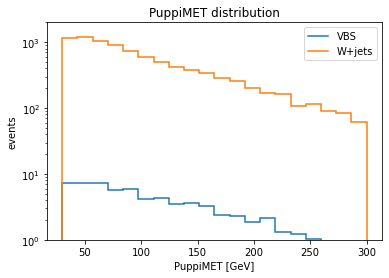

In [12]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["PuppiMET"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["PuppiMET"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["PuppiMET"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["PuppiMET"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["PuppiMET"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["PuppiMET"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["PuppiMET"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["PuppiMET"]*(x1/n1)+out["bkg_WJets_100To200"]["PuppiMET"]*(x2/n2)+out["bkg_WJets_200To400"]["PuppiMET"]*(x3/n3)+out["bkg_WJets_400To600"]["PuppiMET"]*(x4/n4)+out["bkg_WJets_600To800"]["PuppiMET"]*(x5/n5)+out["bkg_WJets_800To1200"]["PuppiMET"]*(x6/n6)+out["bkg_WJets_1200To2500"]["PuppiMET"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["PuppiMET"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("PuppiMET [GeV]")
plt.ylim(1,2e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("PuppiMET distribution")
plt.legend()

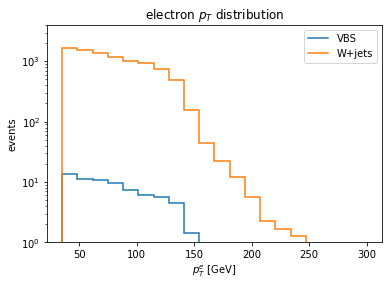

In [15]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["e_pT"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["e_pT"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["e_pT"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["e_pT"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["e_pT"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["e_pT"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["e_pT"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["e_pT"]*(x1/n1)+out["bkg_WJets_100To200"]["e_pT"]*(x2/n2)+out["bkg_WJets_200To400"]["e_pT"]*(x3/n3)+out["bkg_WJets_400To600"]["e_pT"]*(x4/n4)+out["bkg_WJets_600To800"]["e_pT"]*(x5/n5)+out["bkg_WJets_800To1200"]["e_pT"]*(x6/n6)+out["bkg_WJets_1200To2500"]["e_pT"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["e_pT"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$p_{T}^{e}$ [GeV]")
plt.ylim(1,4e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("electron $p_{T}$ distribution")
plt.legend()

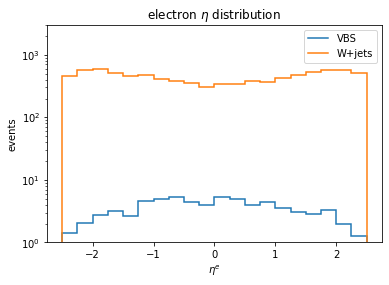

In [17]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["e_eta"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["e_eta"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["e_eta"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["e_eta"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["e_eta"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["e_eta"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["e_eta"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["e_eta"]*(x1/n1)+out["bkg_WJets_100To200"]["e_eta"]*(x2/n2)+out["bkg_WJets_200To400"]["e_eta"]*(x3/n3)+out["bkg_WJets_400To600"]["e_eta"]*(x4/n4)+out["bkg_WJets_600To800"]["e_eta"]*(x5/n5)+out["bkg_WJets_800To1200"]["e_eta"]*(x6/n6)+out["bkg_WJets_1200To2500"]["e_eta"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["e_eta"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$\eta^{e}$")
plt.ylim(1,3e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("electron $\eta$ distribution")
plt.legend()

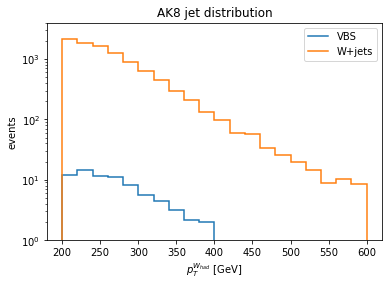

In [19]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["fatjet_pT"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["fatjet_pT"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["fatjet_pT"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["fatjet_pT"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["fatjet_pT"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["fatjet_pT"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["fatjet_pT"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["fatjet_pT"]*(x1/n1)+out["bkg_WJets_100To200"]["fatjet_pT"]*(x2/n2)+out["bkg_WJets_200To400"]["fatjet_pT"]*(x3/n3)+out["bkg_WJets_400To600"]["fatjet_pT"]*(x4/n4)+out["bkg_WJets_600To800"]["fatjet_pT"]*(x5/n5)+out["bkg_WJets_800To1200"]["fatjet_pT"]*(x6/n6)+out["bkg_WJets_1200To2500"]["fatjet_pT"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["fatjet_pT"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$p_{T}^{W_{had}}$ [GeV]")
plt.ylim(1,4e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("AK8 jet distribution")
plt.legend()

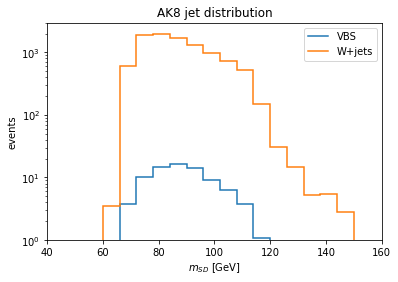

In [62]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["fatjet_mass"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["fatjet_mass"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["fatjet_mass"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["fatjet_mass"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["fatjet_mass"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["fatjet_mass"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["fatjet_mass"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["fatjet_mass"]*(x1/n1)+out["bkg_WJets_100To200"]["fatjet_mass"]*(x2/n2)+out["bkg_WJets_200To400"]["fatjet_mass"]*(x3/n3)+out["bkg_WJets_400To600"]["fatjet_mass"]*(x4/n4)+out["bkg_WJets_600To800"]["fatjet_mass"]*(x5/n5)+out["bkg_WJets_800To1200"]["fatjet_mass"]*(x6/n6)+out["bkg_WJets_1200To2500"]["fatjet_mass"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["fatjet_mass"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$m_{SD}$ [GeV]")
plt.xlim(40,160)
plt.ylim(1,3e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("AK8 jet distribution")
plt.legend()

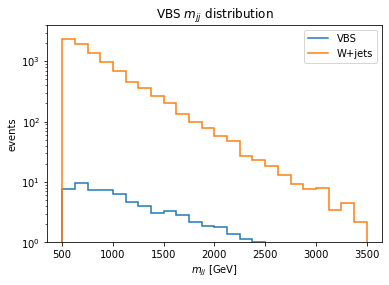

In [25]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["jets_mass"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["jets_mass"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["jets_mass"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["jets_mass"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["jets_mass"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["jets_mass"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["jets_mass"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["jets_mass"]*(x1/n1)+out["bkg_WJets_100To200"]["jets_mass"]*(x2/n2)+out["bkg_WJets_200To400"]["jets_mass"]*(x3/n3)+out["bkg_WJets_400To600"]["jets_mass"]*(x4/n4)+out["bkg_WJets_600To800"]["jets_mass"]*(x5/n5)+out["bkg_WJets_800To1200"]["jets_mass"]*(x6/n6)+out["bkg_WJets_1200To2500"]["jets_mass"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["jets_mass"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$m_{jj}$ [GeV]")
plt.ylim(1,4e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("VBS $m_{jj}$ distribution")
plt.legend()

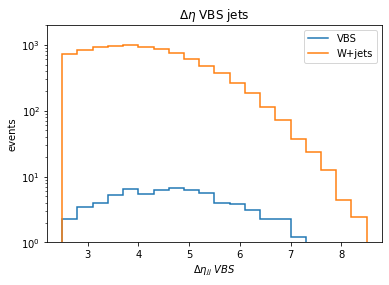

In [29]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["jets_eta"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["jets_eta"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["jets_eta"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["jets_eta"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["jets_eta"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["jets_eta"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["jets_eta"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["jets_eta"]*(x1/n1)+out["bkg_WJets_100To200"]["jets_eta"]*(x2/n2)+out["bkg_WJets_200To400"]["jets_eta"]*(x3/n3)+out["bkg_WJets_400To600"]["jets_eta"]*(x4/n4)+out["bkg_WJets_600To800"]["jets_eta"]*(x5/n5)+out["bkg_WJets_800To1200"]["jets_eta"]*(x6/n6)+out["bkg_WJets_1200To2500"]["jets_eta"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["jets_eta"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$\Delta\eta_{jj} \ VBS$")
plt.ylim(1,2e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("$\Delta\eta$ VBS jets")
plt.legend()

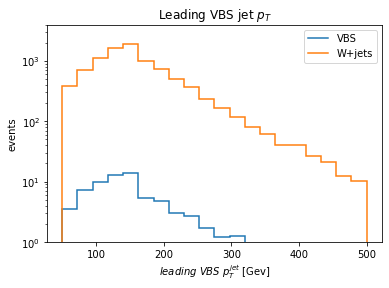

In [31]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["jets_lead"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["jets_lead"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["jets_lead"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["jets_lead"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["jets_lead"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["jets_lead"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["jets_lead"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["jets_lead"]*(x1/n1)+out["bkg_WJets_100To200"]["jets_lead"]*(x2/n2)+out["bkg_WJets_200To400"]["jets_lead"]*(x3/n3)+out["bkg_WJets_400To600"]["jets_lead"]*(x4/n4)+out["bkg_WJets_600To800"]["jets_lead"]*(x5/n5)+out["bkg_WJets_800To1200"]["jets_lead"]*(x6/n6)+out["bkg_WJets_1200To2500"]["jets_lead"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["jets_lead"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$leading \ VBS \ p_{T}^{jet}$ [Gev]")
plt.ylim(1,4e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("Leading VBS jet $p_{T}$")
plt.legend()

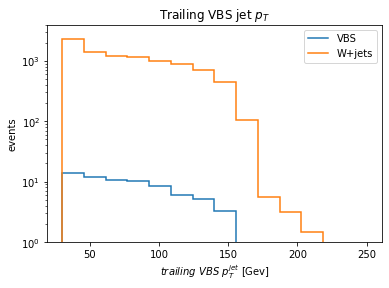

In [33]:
(lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["jets_trail"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["jets_trail"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["jets_trail"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["jets_trail"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["jets_trail"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["jets_trail"]*(xs_sig_MLMH/n_sig_MLMH))).plot(label="VBS")
#(lumi_2018*1000*out["bkg_WJets_LO"]["jets_trail"]*xs_WJets_LO/n_bkg_LO).plot(label="W+jets_LO")
(lumi_2018*1000*(out["bkg_WJets_70To100"]["jets_trail"]*(x1/n1)+out["bkg_WJets_100To200"]["jets_trail"]*(x2/n2)+out["bkg_WJets_200To400"]["jets_trail"]*(x3/n3)+out["bkg_WJets_400To600"]["jets_trail"]*(x4/n4)+out["bkg_WJets_600To800"]["jets_trail"]*(x5/n5)+out["bkg_WJets_800To1200"]["jets_trail"]*(x6/n6)+out["bkg_WJets_1200To2500"]["jets_trail"]*(x7/n7)+out["bkg_WJets_2500ToInf"]["jets_trail"]*(x8/n8))).plot(label="W+jets")
plt.xlabel("$trailing \ VBS \ p_{T}^{jet}$ [Gev]")
plt.ylim(1,4e3)
plt.ylabel("events")
plt.yscale("log")
plt.title("Trailing VBS jet $p_{T}$")
plt.legend()

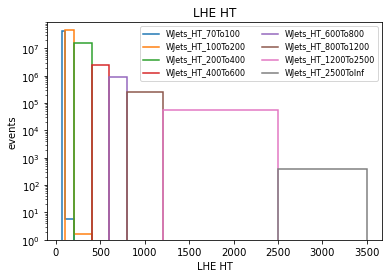

In [41]:
#Instead of the W+jets_LO inclusive sample, I use the HT binned samples
#(out["bkg_WJets_LO"]["LHE_HT"]*lumi_2018*1000*xs_WJets_LO/out["bkg_WJets"]["entries"]).plot()
h_HT_1 = out["bkg_WJets_70To100"]["LHE_HT"]*lumi_2018*1000*x1/n1
h_HT_2 = out["bkg_WJets_100To200"]["LHE_HT"]*lumi_2018*1000*x2/n2
h_HT_3 = out["bkg_WJets_200To400"]["LHE_HT"]*lumi_2018*1000*x3/n3
h_HT_4 = out["bkg_WJets_400To600"]["LHE_HT"]*lumi_2018*1000*x4/n4
h_HT_5 = out["bkg_WJets_600To800"]["LHE_HT"]*lumi_2018*1000*x5/n5
h_HT_6 = out["bkg_WJets_800To1200"]["LHE_HT"]*lumi_2018*1000*x6/n6
h_HT_7 = out["bkg_WJets_1200To2500"]["LHE_HT"]*lumi_2018*1000*x7/n7
h_HT_8 = out["bkg_WJets_2500ToInf"]["LHE_HT"]*lumi_2018*1000*x8/n8
h_HT_1.plot(label="WJets_HT_70To100"), h_HT_2.plot(label="WJets_HT_100To200"), h_HT_3.plot(label="WJets_HT_200To400"), h_HT_4.plot(label="WJets_HT_400To600"), h_HT_5.plot(label="WJets_HT_600To800"), h_HT_6.plot(label="WJets_HT_800To1200"), h_HT_7.plot(label="WJets_HT_1200To2500"), h_HT_8.plot(label="WJets_HT_2500ToInf")
plt.title("LHE HT")
plt.xlabel("LHE HT")
plt.ylim([1., 9e7])
plt.yscale("log")
plt.ylabel("events")
plt.legend(prop={'size':8}, ncol = 2)

In [69]:
#Define histograms to save for future analysis
h_st = lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["t_ratio"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["t_ratio"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["t_ratio"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["t_ratio"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["t_ratio"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["t_ratio"]*(xs_sig_MLMH/n_sig_MLMH))
h_bt1 = out["bkg_WJets_70To100"]["t_ratio"]
h_bt2 = out["bkg_WJets_100To200"]["t_ratio"]
h_bt3 = out["bkg_WJets_200To400"]["t_ratio"]
h_bt4 = out["bkg_WJets_400To600"]["t_ratio"]
h_bt5 = out["bkg_WJets_600To800"]["t_ratio"]
h_bt6 = out["bkg_WJets_800To1200"]["t_ratio"]
h_bt7 = out["bkg_WJets_1200To2500"]["t_ratio"]
h_bt8 = out["bkg_WJets_2500ToInf"]["t_ratio"]
h_bt = (lumi_2018*1000)*(h_bt1*(x1/n1)+h_bt2*(x2/n2)+h_bt3*(x3/n3)+h_bt4*(x4/n4)+h_bt5*(x5/n5)+h_bt6*(x6/n6)+h_bt7*(x7/n7)+h_bt8*(x8/n8))

h_sp = lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["pNet"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["pNet"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["pNet"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["pNet"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["pNet"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["pNet"]*(xs_sig_MLMH/n_sig_MLMH))
h_bp1 = out["bkg_WJets_70To100"]["pNet"]
h_bp2 = out["bkg_WJets_100To200"]["pNet"]
h_bp3 = out["bkg_WJets_200To400"]["pNet"]
h_bp4 = out["bkg_WJets_400To600"]["pNet"]
h_bp5 = out["bkg_WJets_600To800"]["pNet"]
h_bp6 = out["bkg_WJets_800To1200"]["pNet"]
h_bp7 = out["bkg_WJets_1200To2500"]["pNet"]
h_bp8 = out["bkg_WJets_2500ToInf"]["pNet"]
h_bp = (lumi_2018*1000)*(h_bp1*(x1/n1)+h_bp2*(x2/n2)+h_bp3*(x3/n3)+h_bp4*(x4/n4)+h_bp5*(x5/n5)+h_bp6*(x6/n6)+h_bp7*(x7/n7)+h_bp8*(x8/n8))

h_sp_MD = lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["pNet_MD"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["pNet_MD"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["pNet_MD"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["pNet_MD"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["pNet_MD"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["pNet_MD"]*(xs_sig_MLMH/n_sig_MLMH))
h_bp1_MD = out["bkg_WJets_70To100"]["pNet_MD"]
h_bp2_MD = out["bkg_WJets_100To200"]["pNet_MD"]
h_bp3_MD = out["bkg_WJets_200To400"]["pNet_MD"]
h_bp4_MD = out["bkg_WJets_400To600"]["pNet_MD"]
h_bp5_MD = out["bkg_WJets_600To800"]["pNet_MD"]
h_bp6_MD = out["bkg_WJets_800To1200"]["pNet_MD"]
h_bp7_MD = out["bkg_WJets_1200To2500"]["pNet_MD"]
h_bp8_MD = out["bkg_WJets_2500ToInf"]["pNet_MD"]
h_bp_MD = (lumi_2018*1000)*(h_bp1_MD*(x1/n1)+h_bp2_MD*(x2/n2)+h_bp3_MD*(x3/n3)+h_bp4_MD*(x4/n4)+h_bp5_MD*(x5/n5)+h_bp6_MD*(x6/n6)+h_bp7_MD*(x7/n7)+h_bp8_MD*(x8/n8))

h_sd = lumi_2018*1000*(out["sig_WPHADWMLEPjj_EWK"]["dTag"]*(xs_sig_PHML/n_sig_PHML)+out["sig_WPLEPWMHADjj_EWK"]["dTag"]*(xs_sig_MHPL/n_sig_MHPL)+out["sig_WPLEPZHADjj_EWK"]["dTag"]*(xs_sig_PLZH/n_sig_PLZH)+out["sig_WMLEPZHADjj_EWK"]["dTag"]*(xs_sig_MLZH/n_sig_MLZH)+out["sig_WPLEPWPHADjj_EWK"]["dTag"]*(xs_sig_PLPH/n_sig_PLPH)+out["sig_WMLEPWMHADjj_EWK"]["dTag"]*(xs_sig_MLMH/n_sig_MLMH))
h_bd1 = out["bkg_WJets_70To100"]["dTag"]
h_bd2 = out["bkg_WJets_100To200"]["dTag"]
h_bd3 = out["bkg_WJets_200To400"]["dTag"]
h_bd4 = out["bkg_WJets_400To600"]["dTag"]
h_bd5 = out["bkg_WJets_600To800"]["dTag"]
h_bd6 = out["bkg_WJets_800To1200"]["dTag"]
h_bd7 = out["bkg_WJets_1200To2500"]["dTag"]
h_bd8 = out["bkg_WJets_2500ToInf"]["dTag"]
h_bd = (lumi_2018*1000)*(h_bd1*(x1/n1)+h_bd2*(x2/n2)+h_bd3*(x3/n3)+h_bd4*(x4/n4)+h_bd5*(x5/n5)+h_bd6*(x6/n6)+h_bd7*(x7/n7)+h_bd8*(x8/n8))

#Save histograms in file.pkl, need to import pickle
with open("histogram_files/t_ratio.pkl", "wb") as f:
    pickle.dump(h_st, f)
    pickle.dump(h_bt, f)
    pickle.dump(h_bt1, f)
    pickle.dump(h_bt2, f)
    pickle.dump(h_bt3, f)
    pickle.dump(h_bt4, f)
    pickle.dump(h_bt5, f)
    pickle.dump(h_bt6, f)
    pickle.dump(h_bt7, f)
    pickle.dump(h_bt8, f)
with open("histogram_files/pNet.pkl", "wb") as f_p:
    pickle.dump(h_sp, f_p)
    pickle.dump(h_bp, f_p)
    pickle.dump(h_bp1, f_p)
    pickle.dump(h_bp2, f_p)
    pickle.dump(h_bp3, f_p)
    pickle.dump(h_bp4, f_p)
    pickle.dump(h_bp5, f_p)
    pickle.dump(h_bp6, f_p)
    pickle.dump(h_bp7, f_p)
    pickle.dump(h_bp8, f_p)
with open("histogram_files/pNet_MD.pkl", "wb") as f_p_MD:
    pickle.dump(h_sp_MD, f_p_MD)
    pickle.dump(h_bp_MD, f_p_MD)
    pickle.dump(h_bp1_MD, f_p_MD)
    pickle.dump(h_bp2_MD, f_p_MD)
    pickle.dump(h_bp3_MD, f_p_MD)
    pickle.dump(h_bp4_MD, f_p_MD)
    pickle.dump(h_bp5_MD, f_p_MD)
    pickle.dump(h_bp6_MD, f_p_MD)
    pickle.dump(h_bp7_MD, f_p_MD)
    pickle.dump(h_bp8_MD, f_p_MD)
with open("histogram_files/dTag.pkl", "wb") as f_d:
    pickle.dump(h_sd, f_d)
    pickle.dump(h_bd, f_d)
    pickle.dump(h_bd1, f_d)
    pickle.dump(h_bd2, f_d)
    pickle.dump(h_bd3, f_d)
    pickle.dump(h_bd4, f_d)
    pickle.dump(h_bd5, f_d)
    pickle.dump(h_bd6, f_d)
    pickle.dump(h_bd7, f_d)
    pickle.dump(h_bd8, f_d)

In [2]:
#Load histograms from file.pkl
with open("histogram_files/t_ratio.pkl", "rb") as fo:
    h_sig_tau = pickle.load(fo)
    h_bkg_tau = pickle.load(fo)
    h_bkg_tau1 = pickle.load(fo)
    h_bkg_tau2 = pickle.load(fo)
    h_bkg_tau3 = pickle.load(fo)
    h_bkg_tau4 = pickle.load(fo)
    h_bkg_tau5 = pickle.load(fo)
    h_bkg_tau6 = pickle.load(fo)
    h_bkg_tau7 = pickle.load(fo)
    h_bkg_tau8 = pickle.load(fo)
with open("histogram_files/pNet.pkl", "rb") as fo_p:
    h_sig_pNet = pickle.load(fo_p)
    h_bkg_pNet = pickle.load(fo_p)
    h_bkg_pNet1 = pickle.load(fo_p)
    h_bkg_pNet2 = pickle.load(fo_p)
    h_bkg_pNet3 = pickle.load(fo_p)
    h_bkg_pNet4 = pickle.load(fo_p)
    h_bkg_pNet5 = pickle.load(fo_p)
    h_bkg_pNet6 = pickle.load(fo_p)
    h_bkg_pNet7 = pickle.load(fo_p)
    h_bkg_pNet8 = pickle.load(fo_p)
with open("histogram_files/pNet_MD.pkl", "rb") as fo_p_MD:
    h_sig_pNet_MD = pickle.load(fo_p_MD)
    h_bkg_pNet_MD = pickle.load(fo_p_MD)
    h_bkg_pNet1_MD = pickle.load(fo_p_MD)
    h_bkg_pNet2_MD = pickle.load(fo_p_MD)
    h_bkg_pNet3_MD = pickle.load(fo_p_MD)
    h_bkg_pNet4_MD = pickle.load(fo_p_MD)
    h_bkg_pNet5_MD = pickle.load(fo_p_MD)
    h_bkg_pNet6_MD = pickle.load(fo_p_MD)
    h_bkg_pNet7_MD = pickle.load(fo_p_MD)
    h_bkg_pNet8_MD = pickle.load(fo_p_MD)
with open("histogram_files/dTag.pkl", "rb") as fo_d:
    h_sig_dTag = pickle.load(fo_d)
    h_bkg_dTag = pickle.load(fo_d)
    h_bkg_dTag1 = pickle.load(fo_d)
    h_bkg_dTag2 = pickle.load(fo_d)
    h_bkg_dTag3 = pickle.load(fo_d)
    h_bkg_dTag4 = pickle.load(fo_d)
    h_bkg_dTag5 = pickle.load(fo_d)
    h_bkg_dTag6 = pickle.load(fo_d)
    h_bkg_dTag7 = pickle.load(fo_d)
    h_bkg_dTag8 = pickle.load(fo_d)

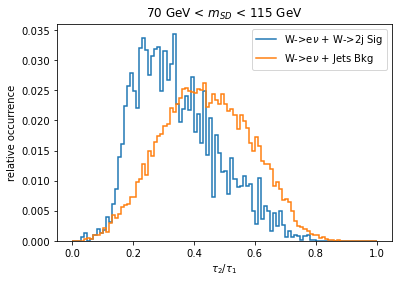

In [3]:
(h_sig_tau/h_sig_tau.sum()).plot(label="W->e$\\nu$ + W->2j Sig")
(h_bkg_tau/h_bkg_tau.sum()).plot(label = "W->e$\\nu$ + Jets Bkg")
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("$\\tau_{2}/\\tau_{1}$")
plt.ylabel("relative occurrence")
plt.legend()

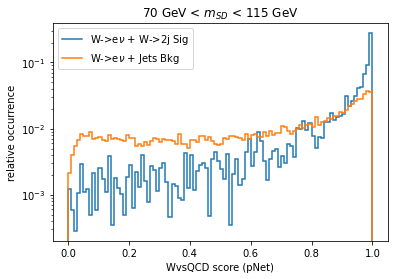

In [61]:
(h_sig_pNet/h_sig_pNet.sum()).plot(label = "W->e$\\nu$ + W->2j Sig")
(h_bkg_pNet/h_bkg_pNet.sum()).plot(label = "W->e$\\nu$ + Jets Bkg")
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("WvsQCD score (pNet)")
plt.ylabel("relative occurrence")
plt.yscale("log")
plt.legend(loc = "upper left")

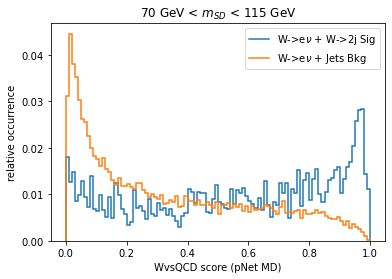

In [46]:
(h_sig_pNet_MD/h_sig_pNet_MD.sum()).plot(label = "W->e$\\nu$ + W->2j Sig")
(h_bkg_pNet_MD/h_bkg_pNet_MD.sum()).plot(label = "W->e$\\nu$ + Jets Bkg")
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("WvsQCD score (pNet MD)")
plt.ylabel("relative occurrence")
#plt.yscale("log")
plt.legend(loc = "upper right")

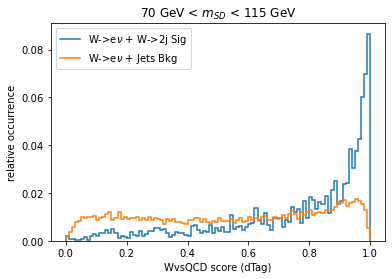

In [47]:
(h_sig_dTag/h_sig_dTag.sum()).plot(label = "W->e$\\nu$ + W->2j Sig")
(h_bkg_dTag/h_bkg_dTag.sum()).plot(label = "W->e$\\nu$ + Jets Bkg")
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("WvsQCD score (dTag)")
plt.ylabel("relative occurrence")
#plt.yscale("log")
plt.legend(loc = "upper left")

In [65]:
#Initialize counters to integrate the histograms
sig_tau, bkg_tau, sig_pNet, bkg_pNet, sig_pNet_MD, bkg_pNet_MD, sig_dTag, bkg_dTag = [0, 0, 0, 0, 0, 0, 0, 0]
#Initialize lists to store the values of the integration
x_sig_tau = [] #signal t_ratio
y_bkg_tau = [] #background t_ratio
x_sig_pNet = [] #signal pNet
y_bkg_pNet = [] #background pNet
x_sig_pNet_MD = [] #signal pNet_MD
y_bkg_pNet_MD = [] #background pNet_MD
x_sig_dTag = [] #signal dTag
y_bkg_dTag = [] #background dTag
y_ratio_tau = [] #signal to square background ratio t_ratio
y_ratio_pNet = [] #signal to square background ratio pNet
y_ratio_pNet_MD = [] #signal to square background ratio pNet_MD
y_ratio_dTag = [] #signal to square background ratio dTag

#Loop over the bins of the histograms to integrate
for j in range(len(h_sig_tau.counts().flatten())): #len(h_sig_tau.counts().flatten()) is the number of bins of the histograms 
    sig_tau = sig_tau + h_sig_tau.counts().flatten()[j]
    bkg_tau = bkg_tau + h_bkg_tau.counts().flatten()[j]
    x_sig_tau.append(sig_tau/h_sig_tau.sum())
    y_bkg_tau.append(bkg_tau/h_bkg_tau.sum())
    if bkg_tau != 0: y_ratio_tau.append(sig_tau/math.sqrt(bkg_tau))
    elif bkg_tau == 0: y_ratio_tau.append(0)
    #For pNet and dTag, I integrate from the upper edge
    l=(len(h_sig_pNet.counts().flatten())-1)-j #Attention, the last bin is nbin-1!
    sig_pNet = sig_pNet + h_sig_pNet.counts().flatten()[l]
    bkg_pNet = bkg_pNet + h_bkg_pNet.counts().flatten()[l]
    sig_pNet_MD = sig_pNet_MD + h_sig_pNet_MD.counts().flatten()[l]
    bkg_pNet_MD = bkg_pNet_MD + h_bkg_pNet_MD.counts().flatten()[l]
    sig_dTag = sig_dTag + h_sig_dTag.counts().flatten()[l]
    bkg_dTag = bkg_dTag + h_bkg_dTag.counts().flatten()[l]
    x_sig_pNet.append(sig_pNet/h_sig_pNet.sum())
    y_bkg_pNet.append(bkg_pNet/h_bkg_pNet.sum())
    x_sig_pNet_MD.append(sig_pNet_MD/h_sig_pNet_MD.sum())
    y_bkg_pNet_MD.append(bkg_pNet_MD/h_bkg_pNet_MD.sum())
    x_sig_dTag.append(sig_dTag/h_sig_dTag.sum())
    y_bkg_dTag.append(bkg_dTag/h_bkg_dTag.sum())
    if bkg_pNet != 0: y_ratio_pNet.append(sig_pNet/math.sqrt(bkg_pNet))
    elif bkg_pNet == 0: y_ratio_pNet.append(0)
    if bkg_pNet_MD != 0: y_ratio_pNet_MD.append(sig_pNet_MD/math.sqrt(bkg_pNet_MD))
    elif bkg_pNet_MD == 0: y_ratio_pNet_MD.append(0)
    if bkg_dTag != 0: y_ratio_dTag.append(sig_dTag/math.sqrt(bkg_dTag))
    elif bkg_dTag == 0: y_ratio_dTag.append(0)
print(x_sig_tau[44], y_bkg_tau[44])

0.7811155394167377 0.5322770789828906


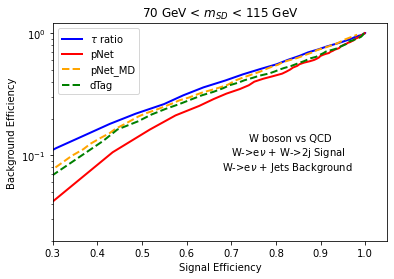

In [51]:
#Plotting the results in a graph
plt.plot(x_sig_tau, y_bkg_tau, label= "$\\tau$ ratio", color='blue', linestyle='solid', linewidth = 2)
         #marker='o', markerfacecolor='blue', markersize=6)
plt.plot(x_sig_pNet, y_bkg_pNet, label= "pNet", color='red', linestyle='solid', linewidth = 2)
         #marker='o', markerfacecolor='red', markersize=6)
plt.plot(x_sig_pNet_MD, y_bkg_pNet_MD, label= "pNet_MD", color='orange', linestyle='dashed', linewidth = 2)
         #marker='o', markerfacecolor='orange', markersize=6)
plt.plot(x_sig_dTag, y_bkg_dTag, label= "dTag", color='green', linestyle='dashed', linewidth = 2)
         #marker='o', markerfacecolor='green', markersize=6)
plt.xlim([0.3, 1.05])
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("Signal Efficiency")
plt.ylim([0.02, 1.2])
plt.yscale("log")
plt.ylabel("Background Efficiency")
plt.text(0.74,0.13,"W boson vs QCD")
plt.text(0.7,0.1,"W->e$\\nu$ + W->2j Signal")
plt.text(0.68,0.075,"W->e$\\nu$ + Jets Background")
plt.legend()

0.8004407341477692
0.8003365646896139


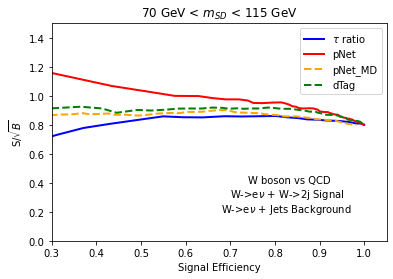

In [60]:
print(y_ratio_tau[len(y_ratio_tau)-1])
print(y_ratio_pNet[len(y_ratio_pNet)-1])
#Plotting the results in a graph
plt.plot(x_sig_tau, y_ratio_tau, label= "$\\tau$ ratio", color='blue', linestyle='solid', linewidth = 2)
         #marker='o', markerfacecolor='blue', markersize=6)
plt.plot(x_sig_pNet, y_ratio_pNet, label= "pNet", color='red', linestyle='solid', linewidth = 2)
         #marker='o', markerfacecolor='red', markersize=6)
plt.plot(x_sig_pNet_MD, y_ratio_pNet_MD, label= "pNet_MD", color='orange', linestyle='dashed', linewidth = 2)
         #marker='o', markerfacecolor='orange', markersize=6)
plt.plot(x_sig_dTag, y_ratio_dTag, label= "dTag", color='green', linestyle='dashed', linewidth = 2)
         #marker='o', markerfacecolor='green', markersize=6)
plt.title("70 GeV < $m_{SD}$ < 115 GeV")
plt.xlabel("Signal Efficiency")
plt.xlim([0.3, 1.05])
plt.ylim([0., 1.5])
#plt.yscale("log")
plt.ylabel("S/$\sqrt{B}$")
plt.text(0.74,0.4,"W boson vs QCD")
plt.text(0.7,0.3,"W->e$\\nu$ + W->2j Signal")
plt.text(0.68,0.2,"W->e$\\nu$ + Jets Background")
plt.legend()